# TF 2.0 의 기능을 테스트 

* autograph

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
#import tensorflow_addons as tfa
from tensorflow.keras import datasets, layers, models, preprocessing
from tensorflow.python.client import device_lib
import timeit
import tensorflow_datasets as tfds

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)

# Autograph 

* tf.function decorator를 씌우면 자동 변환
* 최상위만 씌우면 나머지는 알아서..
* to_code로 확인
* decorated 안한 것 대비 그래프 최적화가 되서 수 배 차이


In [3]:
def exercise_autograph():

    cell = tf.keras.layers.LSTMCell(100)
    
    @tf.function
    def tf_fn(input, state):
        return cell(input,state)

    input = tf.zeros([100,100])
    state = [tf.zeros([100,100])] * 2
    
    # 워밍업
    cell(input, state)
    tf_fn(input, state)

    graph_time = timeit.timeit(lambda: cell(input, state), number=100)
    autograph_time = timeit.timeit(lambda: tf_fn(input, state), number=100)
    
    print(graph_time, autograph_time)

    print(tf.autograph.to_code(tf_fn.python_function, experimental_optional_features=None))
    
exercise_autograph()


0.03972745400005806 0.01601803599987761
def tf__tf_fn(input, state):
    do_return = False
    retval_ = ag__.UndefinedReturnValue()
    with ag__.FunctionScope('tf_fn', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        try:
            do_return = True
            retval_ = fscope.mark_return_value(ag__.converted_call(cell, (input, state), None, fscope))
        except:
            do_return = False
            raise
    (do_return,)
    return ag__.retval(retval_)



# Keras의 함수적 API 예시

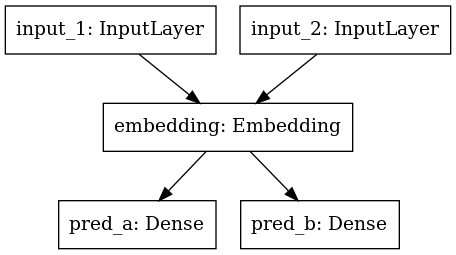

In [4]:
def build_model():
    
    text_input_a = tf.keras.Input(shape=(None, ), dtype='int32')
    text_input_b = tf.keras.Input(shape=(None, ), dtype='int32')
    
    shared_emb = tf.keras.layers.Embedding(1000,128)
    
    enc_input_a = shared_emb(text_input_a)
    enc_input_b = shared_emb(text_input_b)
    
    pred_a = tf.keras.layers.Dense(1, activation='sigmoid', 
        name='pred_a')(enc_input_a)
    
    pred_b = tf.keras.layers.Dense(1, activation='sigmoid', 
        name='pred_b')(enc_input_b)
    
    
    model = tf.keras.Model(inputs=[text_input_a, text_input_b],
        outputs=[pred_a, pred_b])
    
    return model 
    
model = build_model()
tf.keras.utils.plot_model(model, to_file='model.png')    
    

# 모델 서브클래싱으로 모델링 

* init, build, call, get_config, from_config

In [5]:
class MyLayer(layers.Layer):
    
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
            shape=(input_shape[1], self.output_dim), initializer='uniform', trainable=True)
    
        
    def call(self, inputs):
        return tf.matmul(inputs, self.kernel)
        
def test_my_layer():
    
    layer = MyLayer(output_dim=3)
    y = layer(tf.ones([5, 4]))
    
    #print(y)
    
    print(layer.weights[0].shape)
    print(len(layer.weights))
    print(len(layer.trainable_weights))
    print(len(layer.non_trainable_weights))  
    print(layer.trainable)
    print(layer.input_spec)
    print(layer.losses)
    
test_my_layer()

(4, 3)
1
1
0
True
None
[]


## 모델 서브 클래싱시에 add_loss 사용하기 

## 모델 가중치 저장/로드

In [ ]:
model.save_weight(/path/to/save)
model.load_weights(/path/to/save)

# to and from json
json_string = model.to_json()    # or to_yaml
model = tf.keras.models.model_from_json(json_string)


In [61]:
# A layer that creates an activity regularization loss
class ActivityRegularizationLayer(keras.layers.Layer):
    def __init__(self, rate=1e-2):
        super(ActivityRegularizationLayer, self).__init__()
        self.rate = rate

    def call(self, inputs):
        self.add_loss(self.rate * tf.reduce_sum(inputs))
        return inputs
    
inputs = keras.Input(shape=(3,))
outputs = ActivityRegularizationLayer()(inputs)
model = keras.Model(inputs, outputs)    

model.losses

[<tf.Tensor 'activity_regularization_layer_6/mul:0' shape=() dtype=float32>]

# 4. 콜백 

In [ ]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]
model.fit(    callbacks=callbacks,)

# 5.tf.data.datasets 으로 훈련

In [69]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'dart',
 'davis',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k

In [75]:
ds = tfds.load('mnist', split='train')
print(ds)
ds = ds.take(1)  # Only take a single example
print(ds)

# iterate하면 key를 통해 tensor에 접근한다.
for example in ds:
    print(list(example.keys()))
    image = example["image"]
    label = example["label"]
    print(image.shape, label)

<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>
<TakeDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>
['image', 'label']
(28, 28, 1) tf.Tensor(4, shape=(), dtype=int64)


In [79]:
# as_supervised를 사용시에는 데이터 세트 대신 튜플을 얻을 수 있다.

ds = tfds.load('mnist', split='train', as_supervised=True)
ds = ds.take(1)

for image, label in ds:  # example is (image, label)
    print(image.shape, label)

(28, 28, 1) tf.Tensor(4, shape=(), dtype=int64)


In [80]:
# tfds.as_numpy 를 사용 tfds.as_numpy 을 변환합니다.
ds = tfds.load('mnist', split='train', as_supervised=True)
ds = ds.take(1)

for image, label in tfds.as_numpy(ds):
    print(type(image), type(label), label)

<class 'numpy.ndarray'> <class 'numpy.int64'> 4


In [82]:
# as_dataframe: pandas dataframe으로 변환해서 얻을 수 있다.
ds, info = tfds.load('mnist', split='train', with_info=True)

tfds.as_dataframe(ds.take(4), info)

,image,label
0,,4
1,,1
2,,0
3,,7


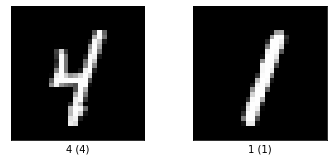

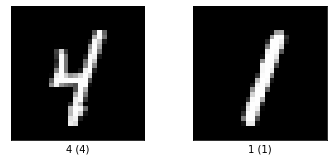

In [87]:
# show example의 사용 

ds, info = tfds.load('mnist', split='train', with_info=True)
#ds = ds.take(1)  # Only take a single example

tfds.show_examples(ds.take(2), info)


In [88]:
# 정보 표시
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/home/hoondori/tensorflow_datasets/mnist/3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


## 선택적 직렬화

In [62]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}


# Now you can recreate the layer from its config:
layer = Linear(64)
config = layer.get_config()
print(config)
new_layer = Linear.from_config(config)

{'units': 64}


# gradient tape로 자신만의 학습 fit 함수 만들기

* Model sublcassing
* train_step redefine
* gradient tape에서 y, x 정의
* 자신만의 loss 정의 (외부에서 줄 필요 없게 됨)
* 자신만의 loss_tracker, metric 정의 

## train_step 재정의 

In [6]:
def simpleCustomModel():

    class CustomModel(keras.Model):
        def train_step(self, data):
            # unpack
            x, y = data

            with tf.GradientTape() as tape:

                y_pred = self(x, training=True) # forward pass

                loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

            # compute g
            trainable_variables = self.trainable_variables
            g = tape.gradient(loss, self.trainable_variables)

            # update w
            self.optimizer.apply_gradients(zip(g, trainable_variables))
            
            # update metrics
            self.compiled_metrics.update_state(y, y_pred)

            # return dict of metrics
            return { m.name: m.result() for m in self.metrics }     

    import numpy as np

    # Construct and compile an instance of CustomModel
    inputs = keras.Input(shape=(32,))
    outputs = keras.layers.Dense(1)(inputs)
    model = CustomModel(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])

    # Just use `fit` as usual
    x = np.random.random((1000, 32))
    y = np.random.random((1000, 1))
    model.fit(x, y, epochs=3)     
simpleCustomModel()

Epoch 1/3
32/32 [==============================] - 0s 751us/step - loss: 0.7846 - mae: 0.7633
Epoch 2/3
32/32 [==============================] - 0s 748us/step - loss: 0.3233 - mae: 0.4585
Epoch 3/3
32/32 [==============================] - 0s 724us/step - loss: 0.2341 - mae: 0.3908


## 낮은 수준 구현 

* Model internal 손실과 Metric 정의
  * 정의 손실과 Metric의 update state 을 손수 해준다.
* 모델 컴파일시 이제는 exernal loss, metric을 지정해 주지 않는다.

In [7]:
def lowLevelCustomModel():

    loss_tracker = keras.metrics.Mean(name="loss")
    mae_metric = keras.metrics.MeanAbsoluteError(name="mae")
    
    class CustomModel(keras.Model):
        def train_step(self, data):
            # unpack
            x, y = data

            with tf.GradientTape() as tape:

                y_pred = self(x, training=True) # forward pass

                # use model's internal loss
                loss = keras.losses.mean_squared_error(y, y_pred)

            # compute g
            trainable_variables = self.trainable_variables
            g = tape.gradient(loss, self.trainable_variables)

            # update w
            self.optimizer.apply_gradients(zip(g, trainable_variables))
            
            # compute our own metrics
            loss_tracker.update_state(loss)
            mae_metric.update_state(y, y_pred)

            # return dict of metrics
            return { "my_loss": loss_tracker.result(), "my_mae": mae_metric.result() }     

    import numpy as np

    # Construct and compile an instance of CustomModel
    inputs = keras.Input(shape=(32,))
    outputs = keras.layers.Dense(1)(inputs)
    model = CustomModel(inputs, outputs)
    model.compile(optimizer="adam") #, loss="mse", metrics=["mae"])

    # Just use `fit` as usual
    x = np.random.random((1000, 32))
    y = np.random.random((1000, 1))
    model.fit(x, y, epochs=3)     
    
lowLevelCustomModel()

Epoch 1/3
32/32 [==============================] - 0s 738us/step - my_loss: 1.6299 - my_mae: 1.1668
Epoch 2/3
32/32 [==============================] - 0s 755us/step - my_loss: 1.1200 - my_mae: 0.9225
Epoch 3/3
32/32 [==============================] - 0s 753us/step - my_loss: 0.8444 - my_mae: 0.7652


## Sample weight 및  class weight  지원

* data에서 sw 전달
* unpack data
* compiled_loss에 sw, cw 전달
* metric update_state 시에도 sw 전달 필요

In [8]:
def SampleWeightCustomModel():

    class CustomModel(keras.Model):
        def train_step(self, data):
            # unpack
            x, y, sw = data

            with tf.GradientTape() as tape:

                y_pred = self(x, training=True) # forward pass

                loss = self.compiled_loss(y, y_pred, 
                    sample_weight=sw,                      
                    regularization_losses=self.losses)

            # compute g
            trainable_variables = self.trainable_variables
            g = tape.gradient(loss, self.trainable_variables)

            # update w
            self.optimizer.apply_gradients(zip(g, trainable_variables))
            
            # update metrics
            self.compiled_metrics.update_state(y, y_pred, sample_weight=sw)

            # return dict of metrics
            return { m.name: m.result() for m in self.metrics }     

    import numpy as np

    # Construct and compile an instance of CustomModel
    inputs = keras.Input(shape=(32,))
    outputs = keras.layers.Dense(1)(inputs)
    model = CustomModel(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])

    # You can now use sample_weight argument
    x = np.random.random((1000, 32))
    y = np.random.random((1000, 1))
    sw = np.random.random((1000, 1))
    model.fit(x, y, sample_weight=sw, epochs=3)
    
SampleWeightCustomModel()

Epoch 1/3
32/32 [==============================] - 0s 783us/step - loss: 2.2923 - mae: 2.0717
Epoch 2/3
32/32 [==============================] - 0s 769us/step - loss: 1.3720 - mae: 1.5699
Epoch 3/3
32/32 [==============================] - 0s 799us/step - loss: 0.7871 - mae: 1.1423


## 자신의 평가 단계 제공 (model.evaluate 재작성)

* test_step 재정의

In [9]:
def MyOwnEvaluationCustomModel():

    class CustomModel(keras.Model):
        def test_step(self, data):
            # Unpack the data
            x, y = data
            # Compute predictions
            y_pred = self(x, training=False)
            # Updates the metrics tracking the loss
            self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            # Update the metrics.
            self.compiled_metrics.update_state(y, y_pred)
            # Return a dict mapping metric names to current value.
            # Note that it will include the loss (tracked in self.metrics).
            return {m.name: m.result() for m in self.metrics}


    # Construct an instance of CustomModel
    inputs = keras.Input(shape=(32,))
    outputs = keras.layers.Dense(1)(inputs)
    model = CustomModel(inputs, outputs)
    model.compile(loss="mse", metrics=["mae"])

    # Evaluate with our custom test_step
    x = np.random.random((1000, 32))
    y = np.random.random((1000, 1))
    model.evaluate(x, y)
    
MyOwnEvaluationCustomModel()

32/32 [==============================] - 0s 643us/step - loss: 0.2098 - mae: 0.3705


## 마무리 : EndToEnd GAN


In [4]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
#import tensorflow_addons as tfa
from tensorflow.keras import datasets, layers, models, preprocessing
from tensorflow.python.client import device_lib
import timeit
import tensorflow_datasets as tfds

def SimpleGAN(epochs=1):
    
    def build_model(latent_dim):
    
        # create discriminator
        discriminator = keras.Sequential(
            [
                keras.Input(shape=(28, 28, 1)),
                layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
                layers.LeakyReLU(alpha=0.2),
                layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
                layers.LeakyReLU(alpha=0.2),
                layers.GlobalMaxPooling2D(),
                layers.Dense(1),
            ],
            name="discriminator",
        )

        # Create the generator
        generator = keras.Sequential(
            [
                keras.Input(shape=(latent_dim,)),
                # We want to generate 128 coefficients to reshape into a 7x7x128 map
                layers.Dense(7 * 7 * 128),
                layers.LeakyReLU(alpha=0.2),
                layers.Reshape((7, 7, 128)),
                layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                layers.LeakyReLU(alpha=0.2),
                layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                layers.LeakyReLU(alpha=0.2),
                layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
            ],
            name="generator",
        )
        
        return discriminator, generator
    
    class GAN(keras.Model):
        def __init__(self, discriminator, generator, latent_dim):
            super(GAN, self).__init__()
            self.discriminator = discriminator
            self.generator = generator
            self.latent_dim = latent_dim
        
        
        def compile(self, d_opt, g_opt, loss_fn):
            super(GAN, self).compile()
            self.d_opt = d_opt
            self.g_opt = g_opt
            self.loss_fn = loss_fn
        
        def train_step(self, real_images):
            
            if isinstance(real_images, tuple):
                real_images = real_imaages[0]
                
            # sampl random points in latent space
            batch_size = tf.shape(real_images)[0]
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            # fake image generation by generator
            gen_images = self.generator(random_latent_vectors)
            
            
            #### train the discriminator
            
            # combine real/fake images
            combined_images = tf.concat([gen_images, real_images], axis=0)
            # prepare labels (fake -> 1, real->0)
            labels = tf.concat([tf.ones(batch_size,1), tf.zeros(batch_size,1)], axis=0)
            # add label noise 
            labels += 0.05 * tf.random.uniform(tf.shape(labels))
            with tf.GradientTape() as tape:
                preds = self.discriminator(combined_images)
                d_loss = self.loss_fn(labels, preds)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_opt.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            
            ### train the generator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            misleading_labels = tf.zeros((batch_size, 1))
            
            with tf.GradientTape() as tape:
                preds = self.discriminator(self.generator(random_latent_vectors))
                g_loss = self.loss_fn(misleading_labels, preds)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_opt.apply_gradients(
                zip(grads, self.generator.trainable_weights)
            )
            
            return {"d_loss": d_loss, "g_loss": g_loss}
        
    # Prepare the dataset. We use both the training & test MNIST digits.
    batch_size = 64   
    
    (X_train, _), (x_test, _) = keras.datasets.mnist.load_data()
    all_digits = np.concatenate([X_train, x_test])
    all_digits = all_digits.astype("float32") / 255.0
    all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
    dataset = tf.data.Dataset.from_tensor_slices(all_digits)
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
    
    # model
    latent_dim = 128
    discriminator, generator = build_model(latent_dim=latent_dim)
    
    gan = GAN(discriminator, generator, latent_dim=latent_dim)
    gan.compile(
        d_opt=keras.optimizers.Adam(learning_rate=0.0003),
        g_opt=keras.optimizers.Adam(learning_rate=0.0003),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
    )
    
    gan.fit(dataset.take(100), epochs=epochs)
            
SimpleGAN(epochs=3)

Epoch 1/3
100/100 [==============================] - 2s 16ms/step - d_loss: 0.5195 - g_loss: 0.8054
Epoch 2/3
100/100 [==============================] - 2s 16ms/step - d_loss: 0.3302 - g_loss: 1.3691
Epoch 3/3
100/100 [==============================] - 2s 16ms/step - d_loss: 0.5003 - g_loss: 1.3242
